In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import norm

# Problem 1

In [2]:
sigma = np.sqrt(0.01)  
n = 10000  # Number of simulations
Pt_1 = 100  # Price at t_1


rt = np.random.normal(0, sigma, n)

In [3]:
# Classical Brownian Motion
Pt_CBM = Pt_1 + rt

# Arithmetic Return System
Pt_ARS = Pt_1 * (1 + rt)

# Geometric Brownian Motion
Pt_GBM = Pt_1 * np.exp(rt)

In [4]:
# Calculate the mean and standard deviation of the simulated prices for each method
simulated_mean_CBM = np.mean(Pt_CBM)
simulated_std_CBM = np.std(Pt_CBM)

simulated_mean_ARS = np.mean(Pt_ARS)
simulated_std_ARS = np.std(Pt_ARS)

simulated_mean_GBM = np.mean(Pt_GBM)
simulated_std_GBM = np.std(Pt_GBM)

In [5]:
# Calculate the mean and standard deviation of the expected prices for each method
expected_mean_CBM = Pt_1
expected_std_CBM = sigma

expected_mean_ARS = Pt_1
expected_std_ARS = Pt_1 * sigma

expected_mean_GBM = Pt_1 * np.exp(0.005)
expected_std_GBM = Pt_1 * np.sqrt(np.exp(0.01) - 1)

In [6]:
# Print the results for comparison
print("===== Comparison of Results =====")
print(f"Classical Brownian Motion (CBM):")
print(f"  Expected Mean: {expected_mean_CBM}, Simulated Mean: {simulated_mean_CBM}")
print(f"  Expected Std: {expected_std_CBM}, Simulated Std: {simulated_std_CBM}\n")

print(f"Arithmetic Return System (ARS):")
print(f"  Expected Mean: {expected_mean_ARS}, Simulated Mean: {simulated_mean_ARS}")
print(f"  Expected Std: {expected_std_ARS}, Simulated Std: {simulated_std_ARS}\n")

print(f"Geometric Brownian Motion (GBM):")
print(f"  Expected Mean: {expected_mean_GBM}, Simulated Mean: {simulated_mean_GBM}")
print(f"  Expected Std: {expected_std_GBM}, Simulated Std: {simulated_std_GBM}\n")

===== Comparison of Results =====
Classical Brownian Motion (CBM):
  Expected Mean: 100, Simulated Mean: 100.00043474493789
  Expected Std: 0.1, Simulated Std: 0.09994562349697608

Arithmetic Return System (ARS):
  Expected Mean: 100, Simulated Mean: 100.04347449378847
  Expected Std: 10.0, Simulated Std: 9.99456234969761

Geometric Brownian Motion (GBM):
  Expected Mean: 100.5012520859401, Simulated Mean: 100.54417910146658
  Expected Std: 10.025052161544073, Simulated Std: 10.068485384172567



In [7]:
methods = ['CBM', 'ARS', 'GBM']

expected_means = [expected_mean_CBM, expected_mean_ARS, expected_mean_GBM]
simulated_means = [simulated_mean_CBM, simulated_mean_ARS, simulated_mean_GBM]

expected_stds = [expected_std_CBM, expected_std_ARS, expected_std_GBM]
simulated_stds = [simulated_std_CBM, simulated_std_ARS, simulated_std_GBM]

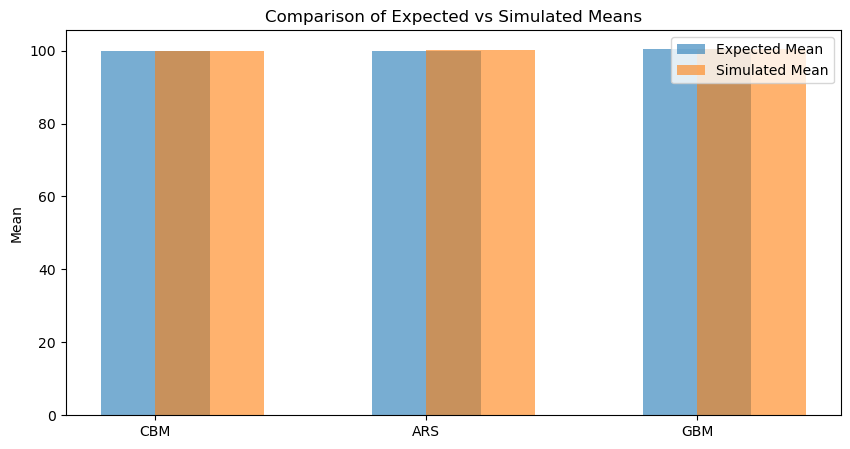

In [8]:
# Visualize the comparison of means
plt.figure(figsize=(10, 5))
plt.bar(methods, expected_means, width=0.4, label='Expected Mean', align='center', alpha=0.6)
plt.bar(methods, simulated_means, width=0.4, label='Simulated Mean', align='edge', alpha=0.6)
plt.title('Comparison of Expected vs Simulated Means')
plt.ylabel('Mean')
plt.legend()
plt.show()

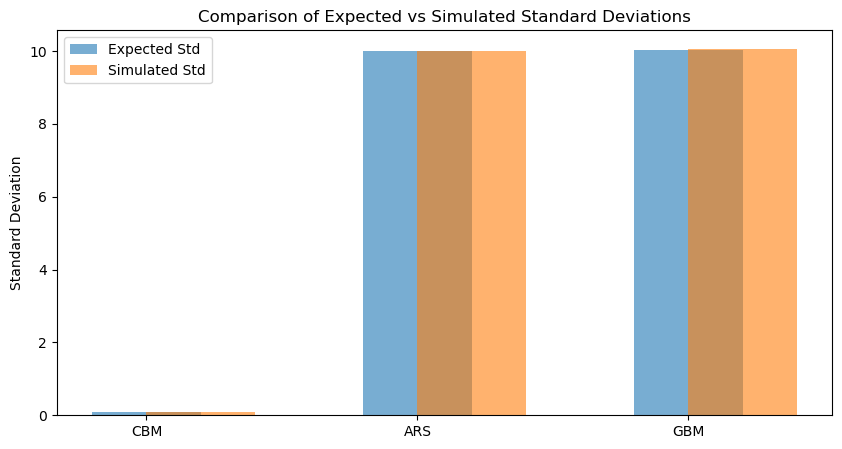

In [9]:
# Visualize the comparison of standard deviations
plt.figure(figsize=(10, 5))
plt.bar(methods, expected_stds, width=0.4, label='Expected Std', align='center', alpha=0.6)
plt.bar(methods, simulated_stds, width=0.4, label='Simulated Std', align='edge', alpha=0.6)
plt.title('Comparison of Expected vs Simulated Standard Deviations')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

# Problem 2

In [10]:
def return_calculate(prices, method="DISCRETE", date_column="Date"):
    # Make sure date column exists
    if date_column not in prices.columns:
        raise ValueError(f"dateColumn: {date_column} not in DataFrame")
    
    # Choose all columns except for date
    cols = [col for col in prices.columns if col != date_column]
    
    # Extract Price data
    p = prices[cols].values
    n, m = p.shape
    
    # Calculate price ratios at consecutive points in time
    p2 = p[1:, :] / p[:-1, :]
    
    # Calculate rate of return based on method
    if method.upper() == "DISCRETE":
        p2 -= 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\", \"DISCRETE\")")
    
    # Create a DataFrame containing the results
    out = pd.DataFrame(p2, columns=cols)
    out[date_column] = prices[date_column].values[1:]
    
    return out

In [11]:
# Load the price data from CSV
prices = pd.read_csv('DailyPrices.csv')

# Calculate arithmetic returns
returns = return_calculate(prices, method="DISCRETE", date_column="Date")

In [12]:
# Remove the mean from the series so that mean(META) = 0
returns['META'] -= returns['META'].mean()

# Define the confidence level for VaR
confidence_level = 0.05

In [13]:
# Using a normal distribution
def var_normal(returns, confidence_level):
    mean = returns.mean()
    std_dev = returns.std()
    return mean + std_dev * stats.norm.ppf(confidence_level)

In [14]:
# Using a normal distribution with Exponentially Weighted variance (λ = 0.94)
def var_ewma(returns, confidence_level, lam=0.94):
    # Calculate exponentially weighted variance
    weights = np.array([(1 - lam) * lam**i for i in range(len(returns))][::-1])
    ewma_variance = np.sum(weights * (returns - returns.mean())**2)
    ewma_std_dev = np.sqrt(ewma_variance)
    return returns.mean() + ewma_std_dev * stats.norm.ppf(confidence_level)

In [15]:
# Using an MLE fitted T-distribution
def var_MLE_t(returns, confidence_level):
    df, loc, scale = stats.t.fit(returns)
    return stats.t.ppf(confidence_level, df, loc=loc, scale=scale)

In [16]:
# Using a fitted AR(1) model
def var_AR1(returns, confidence_level):
    model = AutoReg(returns, lags=1).fit()
    
    # Calculate the standard deviation of the residuals (innovations)
    ar1_std = np.std(model.resid)
    
    # Calculate the VaR using the standard deviation of residuals and the normal distribution
    return ar1_std * stats.norm.ppf(confidence_level)

In [17]:
# Using a historical sumulation
def var_historical(returns, confidence_level, num_draws=10000):
    # Calculate Current Portfolio Value for 1 share of META
    current_portfolio_value = returns.iloc[-1]  

    # Simulate N draws from history with replacement
    simulated_returns = np.random.choice(returns.values, size=(num_draws, len(returns)), replace=True)

    # Calculate new prices from the returns
    portfolio_values_simulated = current_portfolio_value * (1 + simulated_returns).prod(axis=1)

    # Find the alpha percentile of the simulated portfolio values
    var_value = np.percentile(portfolio_values_simulated, confidence_level * 100)

    # Calculate VaR
    var_result = current_portfolio_value - var_value
    return -var_result

In [18]:
# Calculate VaR for META using different methods
meta_returns = returns['META']

var_normal_value = var_normal(meta_returns, confidence_level)
var_ewma_value = var_ewma(meta_returns, confidence_level)
var_MLE_t_value = var_MLE_t(meta_returns, confidence_level)
var_AR1_value = var_AR1(meta_returns, confidence_level)
var_historical_value = var_historical(meta_returns, confidence_level, n)

In [19]:
# Print the results
print(f"VaR (Normal Distribution): {var_normal_value}")
print(f"VaR (Exponentially Weighted Variance): {var_ewma_value}")
print(f"VaR (MLE Fitted T-Distribution): {var_MLE_t_value}")
print(f"VaR (Fitted AR(1) Model): {var_AR1_value}")
print(f"VaR (Historical Simulation): {var_historical_value}")

VaR (Normal Distribution): -0.038249838724583034
VaR (Exponentially Weighted Variance): -0.03099142422297602
VaR (MLE Fitted T-Distribution): -0.03242585900409048
VaR (Fitted AR(1) Model): -0.03811666178305521
VaR (Historical Simulation): -0.0016577131646031966


# Problem 3

In [20]:
# Load the portfolio data from CSV
portfolio = pd.read_csv('Portfolio.csv')  

In [21]:
# Check for ticker mismatches
portfolio_stocks = portfolio['Stock'].unique()
price_stocks = prices.columns

# Find mismatches between portfolio and daily prices tickers
mismatched_stocks = set(portfolio_stocks) - set(price_stocks)
if mismatched_stocks:
    print(f"Mismatched tickers: {mismatched_stocks}")

# Filter out mismatched stocks from the portfolio
portfolio_filtered = portfolio[~portfolio['Stock'].isin(mismatched_stocks)]

Mismatched tickers: {'VRTX', 'BSX', 'ELV', 'CI', 'SLB', 'CB', 'ETN', 'REGN', 'MMC', 'PGR'}


In [22]:
# Function to compute the Exponentially Weighted Covariance Matrix (EWCM)
def exp_weighted_cov(returns, lambda_):
    T, N = returns.shape  # T: number of time periods, N: number of assets
    weights = np.array([(1-lambda_)*lambda_**i for i in range(T)])
    weights = weights / weights.sum()  # Normalize the weights
    
    # Mean of the returns weighted by exponential weights
    weighted_mean = np.average(returns, axis=0, weights=weights)
    
    # Compute the weighted covariance matrix
    cov_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            cov_ij = np.sum(weights * (returns[:, i] - weighted_mean[i]) * (returns[:, j] - weighted_mean[j]))
            cov_matrix[i, j] = cov_ij
            cov_matrix[j, i] = cov_ij
    
    return cov_matrix

In [23]:
# Function to calculate VaR for a given portfolio using the EWCM
def calculate_var(portfolio_weights, cov_matrix, stock_list, all_stocks, confidence_level=0.05):
    # Find the indices of the portfolio stocks in the full list of all stocks
    stock_indices = [all_stocks.index(stock) for stock in stock_list if stock in all_stocks]
    
    # Filter the covariance matrix to include only the portfolio stocks
    filtered_cov_matrix = cov_matrix[np.ix_(stock_indices, stock_indices)]
    
    # Portfolio variance
    portfolio_var = np.dot(portfolio_weights.T, np.dot(filtered_cov_matrix, portfolio_weights))
    portfolio_std = np.sqrt(portfolio_var)
    
    # Calculate VaR using the standard deviation and normal distribution quantile
    VaR = portfolio_std * norm.ppf(confidence_level)
    return VaR

In [24]:
# Convert returns DataFrame to NumPy array for cov_matrix calculations
returns_np = returns.drop(columns=["Date", "SPY"]).values

# Use the LOG method
returns_log = return_calculate(prices, method="LOG", date_column="Date")
returns_log_np = returns_log.drop(columns=["Date", "SPY"]).values

# Calculate the exponentially weighted covariance matrix
lambda_ = 0.97
cov_matrix = exp_weighted_cov(returns_np, lambda_)
cov_matrix_log = exp_weighted_cov(returns_log_np, lambda_)

In [25]:
# Get the current prices for each stock
current_prices = prices.iloc[-1]

# Calculate portfolio weights based on holdings and current prices
portfolio_groups = portfolio_filtered.groupby('Portfolio')
portfolio_weights = {}

# Get the full list of stocks 
all_stocks = list(prices.columns.drop(['Date', 'SPY'])) 

for portfolio_name, group in portfolio_groups:
    # Get holdings and stock tickers for the current portfolio
    stocks = group['Stock'].tolist()
    holdings = group['Holding']
    
    # Get the current prices for the stocks in this portfolio
    stock_prices = current_prices[stocks].values
    
    # Calculate total portfolio value
    portfolio_value = np.sum(holdings * stock_prices)
    
    # Calculate the weight of each stock in the portfolio
    portfolio_weights[portfolio_name] = (holdings * stock_prices) / portfolio_value

In [26]:
# Calculate VaR for each portfolio and the total VaR using both covariance matrices (Discrete and Log)
total_var_discrete = 0
total_var_log = 0

for portfolio_name, weights in portfolio_weights.items():
    # Get stocks in the current portfolio
    stocks = portfolio_filtered[portfolio_filtered['Portfolio'] == portfolio_name]['Stock'].tolist()
    weights = weights.values
    
    # Calculate VaR for both discrete and log returns using the filtered covariance matrix
    var_discrete = calculate_var(weights, cov_matrix, stocks, all_stocks)
    var_log = calculate_var(weights, cov_matrix_log, stocks, all_stocks)
    
    # Convert VaR into dollar terms 
    var_discrete_dollar = abs(portfolio_value * var_discrete)
    var_log_dollar = abs(portfolio_value * var_log)
    
    total_var_discrete += var_discrete_dollar
    total_var_log += var_log_dollar
    
    print(f"VaR for Portfolio {portfolio_name} (Discrete Returns): ${var_discrete_dollar:.7f}")
    print(f"VaR for Portfolio {portfolio_name} (Log Returns): ${var_log_dollar:.7f}")

VaR for Portfolio A (Discrete Returns): $16702.3876764
VaR for Portfolio A (Log Returns): $16739.3778306
VaR for Portfolio B (Discrete Returns): $17477.7995283
VaR for Portfolio B (Log Returns): $17487.4399111
VaR for Portfolio C (Discrete Returns): $21007.8554675
VaR for Portfolio C (Log Returns): $21058.9549963


In [27]:
# Print the total VaR for both methods in dollar terms
print(f"Total VaR (Discrete Returns): ${total_var_discrete:.7f}")
print(f"Total VaR (Log Returns): ${total_var_log:.7f}")

Total VaR (Discrete Returns): $55188.0426722
Total VaR (Log Returns): $55285.7727380
